In [111]:
import os
import numpy as np
from scipy.stats import gaussian_kde
import scipy.stats
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator


def plot_loss_over_epochs(train_losses, val_losses, val_mse_losses, finetune_train_losses, finetune_val_losses, finetune_val_mse_losses):
    fig, ax = plt.subplots(3, 2, figsize=(10,15), sharey='row')

    epochs = range(1, len(train_losses)+1)
    epochs_finetune = range(1, len(finetune_train_losses)+1)

    # --- Training subplot
    ax[0, 0].plot(epochs, train_losses, label='Train Loss (Huber)', color='blue')
    ax[0, 0].plot(epochs, val_losses, label='Validation Loss (Huber)', color='red')
    #ax1.plot(epochs, val_mse_losses, label='Validation RMSE', color='navy')

    ax[0, 0].set_title('Training Phase')
    ax[0, 0].set_xlabel('Epoch')
    ax[0, 0].set_ylabel('Loss')
    ax[0, 0].grid(True)
    ax[0, 0].legend()

    # --- Fine-tuning subplot
    ax[0, 1].plot(epochs_finetune, finetune_train_losses, label='Train Loss (MSE)', linestyle='-', color='blue')
    ax[0, 1].plot(epochs_finetune, finetune_val_losses, label='Validation Loss (MSE)', linestyle='-', color='red')
    #ax2.plot(epochs_finetune, finetune_val_mse_losses, label='Validation RMSE', linestyle='--', color='brown')

    ax[0, 1].set_title('Fine-tuning Phase')
    ax[0, 1].set_xlabel('Epoch')
    ax[0, 1].set_ylabel('Loss')
    ax[0, 1].grid(True)
    ax[0, 1].legend()

    ax[1, 0].plot(epochs, val_mse_losses, label='Validation MSE', color='navy')
    ax[1, 0].set_title('Training Phase')
    ax[1, 0].set_xlabel('Epoch')
    ax[1, 0].set_ylabel('Loss')
    ax[1, 0].grid(True)
    ax[1, 0].legend()

    ax[1, 1].plot(epochs_finetune, finetune_val_mse_losses, label='Validation MSE', linestyle='-', color='brown')
    ax[1, 1].set_title('Fine-tuning Phase')
    ax[1, 1].set_xlabel('Epoch')
    ax[1, 1].set_ylabel('Loss')
    ax[1, 1].grid(True)
    ax[1, 1].legend()

    #fig.suptitle('Loss Curves: Training and Fine-tuning', fontsize=16)
    fig.tight_layout()
    return fig, ax

def density_color_mask(x, y, small_size):
    x = np.array(x)
    y = np.array(y)
    xy = (np.vstack([x.ravel(), y.ravel()]))
    if x.shape[0] > small_size:
        small_sample = np.random.choice(range(x.shape[0]), size=small_size)
        z = gaussian_kde(xy[:, small_sample], bw_method='silverman')(xy)
    else:
        z = gaussian_kde(xy, bw_method='silverman')(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    return x, y, z


def plot_correlation(true, prediction, axis, name="", small_size=15000, true_name="true", limit=None):
    if type(true) is tuple or type(true) is list:
        cmaps = ['Purples', 'Greens', 'Reds', 'Blues', 'Oranges', 'YlOrBr',
                 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu',
                 'PuBuGn', 'BuGn', 'YlGn']
        axis.set_xlabel(xlabel=true_name)
        axis.set_ylabel(ylabel="NN estimated")
        if limit is None:
            limit = (true[0].min(), true[0].max())
        if (type(name) is not list) and (type(name) is not tuple or len(name) == 1):
            name = [str(i) for i in range(len(true))]
        for i in range(len(true)):
            limit = (min(limit[0], min(true[i].min(), prediction[i].min())),
                     max(limit[1], max(true[i].max(), prediction[i].max())))
            t, p, z = density_color_mask(true[i], prediction[i], small_size)
            axis.scatter(np.array(t).flatten(),
                         np.array(p).flatten(),
                         c=z, label=name[i], s=1, cmap=cmaps[i])
    else:
        cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
        axis.set_xlabel(xlabel=name + " " + true_name)
        axis.set_ylabel(ylabel=name + " NN estimated")
        if limit is None:
            limit = (min(true.min(), prediction.min()),
                    max(true.max(), prediction.max()))
        t, p, z = density_color_mask(true, prediction, small_size)
        scatter=axis.scatter(np.array(t).flatten(),
                             np.array(p).flatten(),
                             c=z, label=name, s=1, cmap=cmaps[0])
        cbar = plt.colorbar(scatter, ax=axis, pad=0.02)
        cbar.ax.set_ylabel("Points Density", rotation=270, labelpad=-15)
        cbar.set_ticks([z.min(), z.max()])
        cbar.set_ticklabels(['low', 'high'])
    axis.plot([limit[0], limit[1]], [limit[0], limit[1]], c='red', linestyle="dashed", alpha=0.9)
    lgnd = axis.legend(scatterpoints=1, loc='lower right')
    axis.set_facecolor("white")
    limit = (limit[0] - 0.05 * (limit[1] - limit[0]), limit[1] + 0.05 * (limit[1] - limit[0]))
    axis.set(xlim=limit, ylim=limit)
    for i, handle in enumerate(lgnd.legend_handles[0:-1]):
        handle.set_sizes([10.0])
        handle.set_color(matplotlib.cm.get_cmap(cmaps[i])(0.7))
    return axis

In [116]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.amp import GradScaler, autocast
from IPython.display import Audio, display
import numpy as np

# -------- Load and preprocess data --------
def normalize_x (x, max_time=None, mean_energies=None, std_energies=None):
    times = x[:, :, 0]
    if max_time is None:
        max_time = times.max()
    times_normalized = times / max_time

    energies = x[:, :, 1] * 1e-10
    if mean_energies is None:
        mean_energies = energies.mean()
    if std_energies is None:
        std_energies = energies.std()
    energies_normalized = (energies - mean_energies) / std_energies
    return np.concatenate((times_normalized[:,:, np.newaxis], energies_normalized[:,:, np.newaxis]), axis=-1), max_time, mean_energies, std_energies

def normalize_y (y, min_y=None, max_y=None):
    y = np.log(y)
    if min_y is None:
        min_y = y.min()
    if max_y is None:
        max_y = y.max()
    y_normalized = (y - min_y) / (max_y - min_y)
    return y_normalized, min_y, max_y

def unnormalize_y (y, min_y, max_y):
    y = y * (max_y - min_y) + min_y
    return y

x_train, y_train = np.load("./Karlo/extra/trainset_p2000n10000_train.npz").values()
x_test, y_test = np.load("./Karlo/extra/trainset_p2000n2500_test.npz").values()

x_train, max_time, mean_energies, std_energies = normalize_x(x_train)
x_test, _, _, _ = normalize_x(x_test, max_time, mean_energies, std_energies)

y_train, min_y, max_y = normalize_y(y_train[:, -1])
y_test, _, _ = normalize_y(y_test[:, -1], min_y, max_y)

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

dataset = TensorDataset(x_train_tensor, y_train_tensor) #add a tiny little noise
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=256, pin_memory=True)

# -------- Transformer model with Positional Encoding --------
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=2000):
        super().__init__()
        position = torch.arange(0, max_len).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * (-np.log(10000.0) / embed_dim))
        pe = torch.zeros(max_len, embed_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, embed_dim]
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]  # Match sequence length

class ResidualGLU(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.fc = nn.Linear(dim_in, dim_out * 2)
        self.shortcut = nn.Linear(dim_in, dim_out) if dim_in != dim_out else nn.Identity()
        self.bn = nn.BatchNorm1d(dim_out)

    def forward(self, x):
        residual = self.shortcut(x)
        x_proj, gate = self.fc(x).chunk(2, dim=-1)
        x = x_proj * torch.sigmoid(gate)
        return self.bn(x + residual)

class MultiHeadAttentionPooling(nn.Module):
    def __init__(self, embed_dim, num_heads=4):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.query = nn.Parameter(torch.randn(1, 1, embed_dim))

    def forward(self, x):
        batch_size = x.size(0)
        query = self.query.repeat(batch_size, 1, 1)  # [batch_size, 1, embed_dim]
        attn_output, attn_weights = self.mha(query, x, x)
        return attn_output.squeeze(1)  # [batch_size, embed_dim]


class LIVTransformer(nn.Module):
    def __init__(self, input_dim=2, embed_dim=64, num_heads=4, num_layers=4, ff_dim=128, max_len=2000, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads,
            dim_feedforward=ff_dim, dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Updated Multi-Head Attention Pooling here:
        self.attn_pool = MultiHeadAttentionPooling(embed_dim, num_heads=4)

        self.head = nn.Sequential(
            ResidualGLU(embed_dim, 128),
            nn.LeakyReLU(),
            ResidualGLU(128, 64),
            nn.LeakyReLU(),
            ResidualGLU(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding(x)
        x = self.encoder(x)
        x = self.attn_pool(x)
        return self.head(x).squeeze(-1)


    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding(x)
        x = self.encoder(x)
        x = self.attn_pool(x)
        return self.head(x).squeeze(-1)


def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

# -------- Training --------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LIVTransformer().to(device)
model.apply(init_weights)

MSEcriterion = nn.MSELoss()
criterion = nn.HuberLoss()
#criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=25, T_mult=2)

scaler = GradScaler('cuda')

# Early stopping
patience = 20
best_loss = np.inf
trigger_times = 0

train_losses = []
val_losses = []
val_mse_losses = []

for epoch in range(200):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        with autocast('cuda'):
            pred = model(xb)
            loss = criterion(pred, yb)
            loss = torch.nan_to_num(loss, nan=1e5, posinf=1e5, neginf=-1e5)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=4.0)
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.detach().cpu().float().item() * xb.size(0)

    model.eval()
    val_loss = 0.0
    val_MSEloss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            MSEloss = MSEcriterion(unnormalize_y(pred, min_y, max_y), unnormalize_y(yb, min_y, max_y))
            val_loss += loss.item() * xb.size(0)
            val_MSEloss += MSEloss.item() * xb.size(0)

    train_loss /= len(train_dataset)
    val_loss /= len(val_dataset)
    val_MSEloss /= len(val_dataset)
    scheduler.step()
    if epoch > patience:
        if val_loss < best_loss:
            best_loss = val_loss
            trigger_times = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping at epoch", epoch)
                break

    print(f"Epoch {epoch+1:03d} - Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, Val MSE: {val_MSEloss:.5f}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_mse_losses.append(np.sqrt(val_MSEloss))


# Load best model
model.load_state_dict(torch.load("best_model.pt"))

# -------- Optional Fine-tuning --------
# Freeze Transformer encoder and retrain only the head
for param in model.encoder.parameters():
    param.requires_grad = False
criterion = nn.MSELoss()
head_params = list(model.head.parameters())
optimizer = torch.optim.Adam([
    {'params': head_params, 'weight_decay': 1e-5},
], lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=64)

scaler = GradScaler('cuda')

finetune_train_losses = []
finetune_val_losses = []
finetune_val_mse_losses = []


for epoch in range(64):
    train_loss = 0.0
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        with autocast('cuda'):
            pred = model(xb)
            loss = criterion(pred, yb)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=4.0)
        scaler.step(optimizer)
        scaler.update()
        model.eval()
        train_loss += loss.detach().cpu().float().item() * xb.size(0)

    val_loss = 0.0
    val_MSEloss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            MSEloss = MSEcriterion(unnormalize_y(pred, min_y, max_y), unnormalize_y(yb, min_y, max_y))
            val_loss += loss.item() * xb.size(0)
            val_MSEloss += MSEloss.item() * xb.size(0)

    train_loss /= len(train_dataset)
    val_loss /= len(val_dataset)
    val_MSEloss /= len(val_dataset)
    scheduler.step()

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")

    print(f"Finetune Epoch {epoch+1} - Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, Val MSE: {val_MSEloss:.5f}")
    finetune_train_losses.append(train_loss)
    finetune_val_losses.append(val_loss)
    finetune_val_mse_losses.append(np.sqrt(val_MSEloss))

model.load_state_dict(torch.load("best_model.pt"))

# Process test data in batches
batch_size = 128  # Adjust based on available GPU memory
y_pred_list = []

model.eval()
with torch.no_grad():
    for i in range(0, len(x_test_tensor), batch_size):
        batch = x_test_tensor[i:i + batch_size].to(device)
        batch_pred = model(batch)
        y_pred_list.append(batch_pred.cpu().numpy())

# Concatenate predictions and apply exponential transformation
y_pred = np.concatenate(y_pred_list, axis=0)
y_pred = unnormalize_y(y_pred, min_y, max_y)

#display(Audio(np.sin(2*np.pi*440*np.linspace(0, 1, 44100)), rate=44100, autoplay=True))


Epoch 001 - Train Loss: 0.07362, Val Loss: 0.06819, Val MSE: 72.26022
Epoch 002 - Train Loss: 0.02448, Val Loss: 0.05797, Val MSE: 61.43348
Epoch 003 - Train Loss: 0.02292, Val Loss: 0.09537, Val MSE: 101.07605
Epoch 004 - Train Loss: 0.02015, Val Loss: 0.02784, Val MSE: 29.50232
Epoch 005 - Train Loss: 0.01727, Val Loss: 0.01783, Val MSE: 18.88941
Epoch 006 - Train Loss: 0.01508, Val Loss: 0.01400, Val MSE: 14.83912
Epoch 007 - Train Loss: 0.01427, Val Loss: 0.02198, Val MSE: 23.29720
Epoch 008 - Train Loss: 0.01297, Val Loss: 0.01577, Val MSE: 16.71598
Epoch 009 - Train Loss: 0.01229, Val Loss: 0.01499, Val MSE: 15.87992
Epoch 010 - Train Loss: 0.01175, Val Loss: 0.01585, Val MSE: 16.79685
Epoch 011 - Train Loss: 0.01163, Val Loss: 0.02446, Val MSE: 25.91811
Epoch 012 - Train Loss: 0.01093, Val Loss: 0.02205, Val MSE: 23.36863
Epoch 013 - Train Loss: 0.01104, Val Loss: 0.02711, Val MSE: 28.72717
Epoch 014 - Train Loss: 0.01093, Val Loss: 0.01161, Val MSE: 12.29947
Epoch 015 - Train L

/tmp/ipykernel_4446/3733354765.py:105: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  lgnd = axis.legend(scatterpoints=1, loc='lower right')


Text(0.5, 1.0, 'Test Set Correlation')

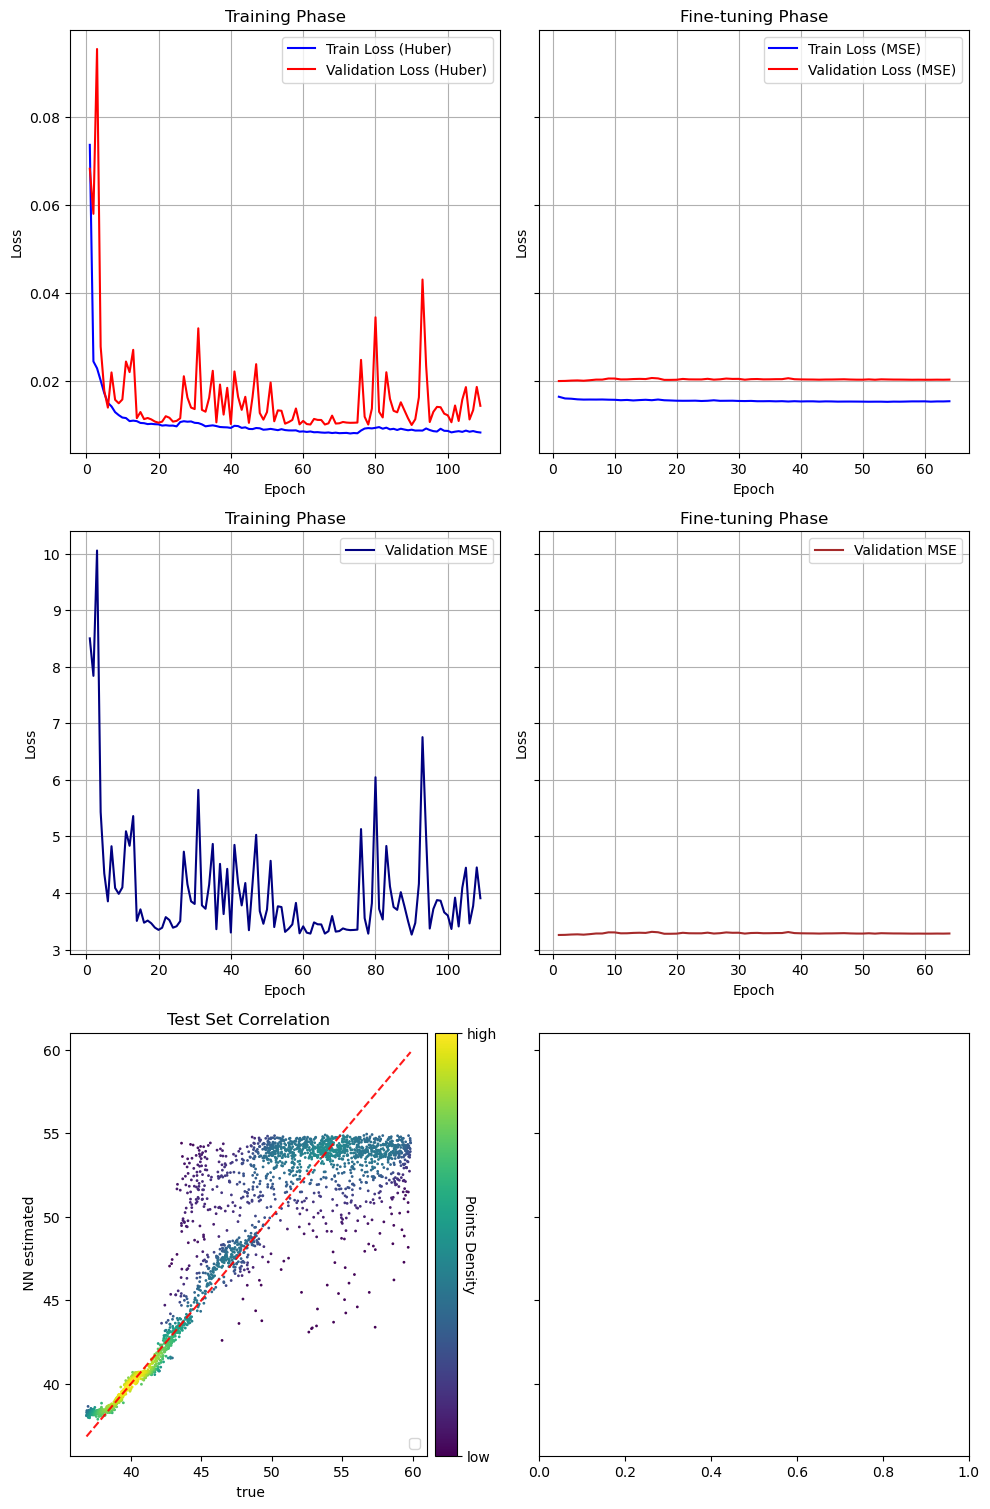

In [118]:
_, ax = plot_loss_over_epochs(train_losses, val_losses, val_mse_losses, finetune_train_losses, finetune_val_losses, finetune_val_mse_losses)
ax[2, 0] = plot_correlation(unnormalize_y(y_test, min_y, max_y), y_pred, ax[2, 0])
ax[2, 0].set_title('Test Set Correlation')

In [67]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.amp import GradScaler, autocast
import numpy as np

# -------- Load and preprocess data --------
def normalize_x (x, max_time=None, mean_energies=None, std_energies=None):
    times = x[:, :, 0]
    if max_time is None:
        max_time = times.max()
    times_normalized = times / max_time

    energies = x[:, :, 1] * 1e-10
    if mean_energies is None:
        mean_energies = energies.mean()
    if std_energies is None:
        std_energies = energies.std()
    energies_normalized = (energies - mean_energies) / std_energies
    return np.concatenate((times_normalized[:,:, np.newaxis], energies_normalized[:,:, np.newaxis]), axis=-1), max_time, mean_energies, std_energies

def normalize_y (y, min_y=None, max_y=None):
    y = np.log(y)
    if min_y is None:
        min_y = y.min()
    if max_y is None:
        max_y = y.max()
    y_normalized = (y - min_y) / (max_y - min_y)
    return y_normalized, min_y, max_y

def unnormalize_y (y, min_y, max_y):
    y = y * (max_y - min_y) + min_y
    return y

x_train, y_train = np.load("./Karlo/extra/trainset_p2000n10000_train.npz").values()
x_test, y_test = np.load("./Karlo/extra/trainset_p2000n2500_test.npz").values()

x_train, max_time, mean_energies, std_energies = normalize_x(x_train)
x_test, _, _, _ = normalize_x(x_test, max_time, mean_energies, std_energies)

y_train, min_y, max_y = normalize_y(y_train[:, -1])
y_test, _, _ = normalize_y(y_test[:, -1], min_y, max_y)

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

dataset = TensorDataset(x_train_tensor, y_train_tensor) #add a tiny little noise
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=256, pin_memory=True)

# -------- Transformer model with Positional Encoding --------
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=2000):
        super().__init__()
        position = torch.arange(0, max_len).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * (-np.log(10000.0) / embed_dim))
        pe = torch.zeros(max_len, embed_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, embed_dim]
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]  # Match sequence length


class AttentionPooling(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.attn = nn.Linear(embed_dim, 1)

    def forward(self, x):
        weights = torch.softmax(self.attn(x), dim=1)
        return (x * weights).sum(dim=1)

class LIVTransformer(nn.Module):
    def __init__(self, input_dim=2, embed_dim=96, num_heads=4, num_layers=4, ff_dim=128, max_len=2000, dropout=0.2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_len=max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads,
                                                   dim_feedforward=ff_dim, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.attn_pool = AttentionPooling(embed_dim)
        self.head = nn.Sequential(
                    nn.BatchNorm1d(embed_dim),
                    nn.Linear(embed_dim, 64),
                    nn.LeakyReLU(),
                    nn.BatchNorm1d(64),
                    nn.Linear(64, 32),
                    nn.LeakyReLU(),
                    nn.BatchNorm1d(32),
                    nn.Linear(32, 16),
                    nn.LeakyReLU(),
                    nn.BatchNorm1d(16),
                    nn.Linear(16, 8),
                    nn.LeakyReLU(),
                    nn.Linear(8, 1),)


    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding(x)
        x = self.encoder(x)
        x = self.attn_pool(x)
        return self.head(x).squeeze(-1)

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

# -------- Training --------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LIVTransformer().to(device)
model.apply(init_weights)

MSEcriterion = nn.MSELoss()
criterion = nn.HuberLoss()
#criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=2)

scaler = GradScaler('cuda')

# Early stopping
patience = 20
best_loss = np.inf
trigger_times = 0

train_losses = []
val_losses = []
val_mse_losses = []

for epoch in range(200):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        with autocast('cuda'):
            pred = model(xb)
            loss = criterion(pred, yb)
            loss = torch.nan_to_num(loss, nan=1e5, posinf=1e5, neginf=-1e5)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.detach().cpu().float().item() * xb.size(0)

    model.eval()
    val_loss = 0.0
    val_MSEloss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            MSEloss = MSEcriterion(unnormalize_y(pred, min_y, max_y), unnormalize_y(yb, min_y, max_y))
            val_loss += loss.item() * xb.size(0)
            val_MSEloss += MSEloss.item() * xb.size(0)

    train_loss /= len(train_dataset)
    val_loss /= len(val_dataset)
    val_MSEloss /= len(val_dataset)
    scheduler.step()
    if epoch > patience:
        if val_loss < best_loss:
            best_loss = val_loss
            trigger_times = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping at epoch", epoch)
                break

    print(f"Epoch {epoch+1:03d} - Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, Val MSE: {val_MSEloss:.5f}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_mse_losses.append(np.sqrt(val_MSEloss))


# Load best model
model.load_state_dict(torch.load("best_model.pt"))

# -------- Optional Fine-tuning --------
# Freeze Transformer encoder and retrain only the head
for param in model.encoder.parameters():
    param.requires_grad = False
criterion = nn.MSELoss()
head_params = list(model.head.parameters())
optimizer = torch.optim.Adam([
    {'params': head_params, 'weight_decay': 1e-5},
], lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

scaler = GradScaler('cuda')

finetune_train_losses = []
finetune_val_losses = []
finetune_val_mse_losses = []


for epoch in range(50):
    train_loss = 0.0
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        with autocast('cuda'):
            pred = model(xb)
            loss = criterion(pred, yb)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        scaler.step(optimizer)
        scaler.update()
        model.eval()
        train_loss += loss.detach().cpu().float().item() * xb.size(0)

    val_loss = 0.0
    val_MSEloss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            MSEloss = MSEcriterion(unnormalize_y(pred, min_y, max_y), unnormalize_y(yb, min_y, max_y))
            val_loss += loss.item() * xb.size(0)
            val_MSEloss += MSEloss.item() * xb.size(0)

    train_loss /= len(train_dataset)
    val_loss /= len(val_dataset)
    val_MSEloss /= len(val_dataset)
    scheduler.step()
    print(f"Finetune Epoch {epoch+1}/50 - Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, Val MSE: {val_MSEloss:.5f}")
    finetune_train_losses.append(train_loss)
    finetune_val_losses.append(val_loss)
    finetune_val_mse_losses.append(np.sqrt(val_MSEloss))
    torch.save(model.state_dict(), "best_model.pt")

Epoch 001 - Train Loss: 0.09800, Val Loss: 0.12125, Val MSE: 130.56740
Epoch 002 - Train Loss: 0.03519, Val Loss: 0.32866, Val MSE: 359.79899
Epoch 003 - Train Loss: 0.02840, Val Loss: 0.15018, Val MSE: 162.07335
Epoch 004 - Train Loss: 0.02579, Val Loss: 0.16218, Val MSE: 174.07204
Epoch 005 - Train Loss: 0.02452, Val Loss: 0.04255, Val MSE: 45.12766
Epoch 006 - Train Loss: 0.02296, Val Loss: 0.03194, Val MSE: 33.84251
Epoch 007 - Train Loss: 0.02209, Val Loss: 0.11761, Val MSE: 124.96925
Epoch 008 - Train Loss: 0.02002, Val Loss: 0.02952, Val MSE: 31.27683
Epoch 009 - Train Loss: 0.01818, Val Loss: 0.03263, Val MSE: 34.57708
Epoch 010 - Train Loss: 0.01717, Val Loss: 0.04423, Val MSE: 46.87741
Epoch 011 - Train Loss: 0.01620, Val Loss: 0.02541, Val MSE: 26.92893
Epoch 012 - Train Loss: 0.01534, Val Loss: 0.02769, Val MSE: 29.34682
Epoch 013 - Train Loss: 0.01509, Val Loss: 0.02466, Val MSE: 26.13018
Epoch 014 - Train Loss: 0.01458, Val Loss: 0.02675, Val MSE: 28.34869
Epoch 015 - Tra

In [80]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.amp import GradScaler, autocast
import numpy as np

# -------- Load and preprocess data --------
def normalize_x (x, max_time=None, mean_energies=None, std_energies=None):
    times = x[:, :, 0]
    if max_time is None:
        max_time = times.max()
    times_normalized = times / max_time

    energies = x[:, :, 1] * 1e-10
    if mean_energies is None:
        mean_energies = energies.mean()
    if std_energies is None:
        std_energies = energies.std()
    energies_normalized = (energies - mean_energies) / std_energies
    return np.concatenate((times_normalized[:,:, np.newaxis], energies_normalized[:,:, np.newaxis]), axis=-1), max_time, mean_energies, std_energies

def normalize_y (y, min_y=None, max_y=None):
    y = np.log(y)
    if min_y is None:
        min_y = y.min()
    if max_y is None:
        max_y = y.max()
    y_normalized = (y - min_y) / (max_y - min_y)
    return y_normalized, min_y, max_y

def unnormalize_y (y, min_y, max_y):
    y = y * (max_y - min_y) + min_y
    return y

x_train, y_train = np.load("./Karlo/extra/trainset_p2000n10000_train.npz").values()
x_test, y_test = np.load("./Karlo/extra/trainset_p2000n2500_test.npz").values()

x_train, max_time, mean_energies, std_energies = normalize_x(x_train)
x_test, _, _, _ = normalize_x(x_test, max_time, mean_energies, std_energies)

y_train, min_y, max_y = normalize_y(y_train[:, -1])
y_test, _, _ = normalize_y(y_test[:, -1], min_y, max_y)

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

dataset = TensorDataset(x_train_tensor, y_train_tensor) #add a tiny little noise
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=256, pin_memory=True)

# -------- Transformer model with Positional Encoding --------
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=2000):
        super().__init__()
        position = torch.arange(0, max_len).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * (-np.log(10000.0) / embed_dim))
        pe = torch.zeros(max_len, embed_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, embed_dim]
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]  # Match sequence length


class AttentionPooling(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.attn = nn.Linear(embed_dim, 1)

    def forward(self, x):
        weights = torch.softmax(self.attn(x), dim=1)
        return (x * weights).sum(dim=1)

class ResidualGLU(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.fc = nn.Linear(dim_in, dim_out * 2)
        self.shortcut = nn.Linear(dim_in, dim_out) if dim_in != dim_out else nn.Identity()
        self.bn = nn.BatchNorm1d(dim_out)

    def forward(self, x):
        residual = self.shortcut(x)
        x_proj, gate = self.fc(x).chunk(2, dim=-1)
        x = x_proj * torch.sigmoid(gate)
        return self.bn(x + residual)


class LIVTransformer(nn.Module):
    def __init__(self, input_dim=2, embed_dim=64, num_heads=4, num_layers=4, ff_dim=128, max_len=2000, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads,
                                                   dim_feedforward=ff_dim, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.attn_pool = AttentionPooling(embed_dim)
        self.head = nn.Sequential(
            ResidualGLU(embed_dim, 128),
            nn.LeakyReLU(),
            ResidualGLU(128, 64),
            nn.LeakyReLU(),
            ResidualGLU(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding(x)
        x = self.encoder(x)
        x = self.attn_pool(x)
        return self.head(x).squeeze(-1)


def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

# -------- Training --------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LIVTransformer().to(device)
model.apply(init_weights)

MSEcriterion = nn.MSELoss()
criterion = nn.HuberLoss()
#criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=2)

scaler = GradScaler('cuda')

# Early stopping
patience = 20
best_loss = np.inf
trigger_times = 0

train_losses = []
val_losses = []
val_mse_losses = []

for epoch in range(200):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        with autocast('cuda'):
            pred = model(xb)
            loss = criterion(pred, yb)
            loss = torch.nan_to_num(loss, nan=1e5, posinf=1e5, neginf=-1e5)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.detach().cpu().float().item() * xb.size(0)

    model.eval()
    val_loss = 0.0
    val_MSEloss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            MSEloss = MSEcriterion(unnormalize_y(pred, min_y, max_y), unnormalize_y(yb, min_y, max_y))
            val_loss += loss.item() * xb.size(0)
            val_MSEloss += MSEloss.item() * xb.size(0)

    train_loss /= len(train_dataset)
    val_loss /= len(val_dataset)
    val_MSEloss /= len(val_dataset)
    scheduler.step()
    if epoch > patience:
        if val_loss < best_loss:
            best_loss = val_loss
            trigger_times = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping at epoch", epoch)
                break

    print(f"Epoch {epoch+1:03d} - Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, Val MSE: {val_MSEloss:.5f}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_mse_losses.append(np.sqrt(val_MSEloss))


# Load best model
model.load_state_dict(torch.load("best_model.pt"))

# -------- Optional Fine-tuning --------
# Freeze Transformer encoder and retrain only the head
for param in model.encoder.parameters():
    param.requires_grad = False
criterion = nn.MSELoss()
head_params = list(model.head.parameters())
optimizer = torch.optim.Adam([
    {'params': head_params, 'weight_decay': 1e-5},
], lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

scaler = GradScaler('cuda')

finetune_train_losses = []
finetune_val_losses = []
finetune_val_mse_losses = []


for epoch in range(64):
    train_loss = 0.0
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        with autocast('cuda'):
            pred = model(xb)
            loss = criterion(pred, yb)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=4.0)
        scaler.step(optimizer)
        scaler.update()
        model.eval()
        train_loss += loss.detach().cpu().float().item() * xb.size(0)

    val_loss = 0.0
    val_MSEloss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            MSEloss = MSEcriterion(unnormalize_y(pred, min_y, max_y), unnormalize_y(yb, min_y, max_y))
            val_loss += loss.item() * xb.size(0)
            val_MSEloss += MSEloss.item() * xb.size(0)

    train_loss /= len(train_dataset)
    val_loss /= len(val_dataset)
    val_MSEloss /= len(val_dataset)
    scheduler.step()

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")

    print(f"Finetune Epoch {epoch+1}/50 - Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, Val MSE: {val_MSEloss:.5f}")
    finetune_train_losses.append(train_loss)
    finetune_val_losses.append(val_loss)
    finetune_val_mse_losses.append(np.sqrt(val_MSEloss))

model.load_state_dict(torch.load("best_model.pt"))

Epoch 001 - Train Loss: 0.07015, Val Loss: 0.05557, Val MSE: 59.17558
Epoch 002 - Train Loss: 0.02757, Val Loss: 0.04485, Val MSE: 47.52773
Epoch 003 - Train Loss: 0.02597, Val Loss: 0.04788, Val MSE: 50.74177
Epoch 004 - Train Loss: 0.02469, Val Loss: 0.02879, Val MSE: 30.50850
Epoch 005 - Train Loss: 0.02402, Val Loss: 0.03586, Val MSE: 38.00193
Epoch 006 - Train Loss: 0.02216, Val Loss: 0.02758, Val MSE: 29.22544
Epoch 007 - Train Loss: 0.01960, Val Loss: 0.02790, Val MSE: 29.56645
Epoch 008 - Train Loss: 0.01743, Val Loss: 0.03201, Val MSE: 33.91978
Epoch 009 - Train Loss: 0.01615, Val Loss: 0.04582, Val MSE: 48.55651
Epoch 010 - Train Loss: 0.01502, Val Loss: 0.05017, Val MSE: 53.16404
Epoch 011 - Train Loss: 0.01470, Val Loss: 0.02996, Val MSE: 31.74418
Epoch 012 - Train Loss: 0.01413, Val Loss: 0.05112, Val MSE: 54.17115
Epoch 013 - Train Loss: 0.01435, Val Loss: 0.02393, Val MSE: 25.36320
Epoch 014 - Train Loss: 0.01308, Val Loss: 0.01707, Val MSE: 18.08846
Epoch 015 - Train Lo

KeyboardInterrupt: 

/tmp/ipykernel_4446/3971389589.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  lgnd = axis.legend(scatterpoints=1, loc='lower right')


<Axes: xlabel=' true', ylabel=' NN estimated'>

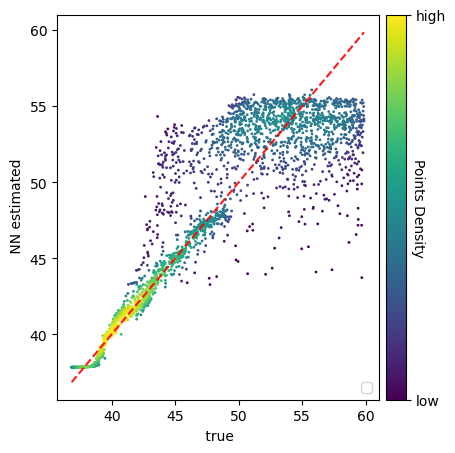

In [94]:
fig_correlation, ax = plt.subplots(figsize=(5, 5))
plot_correlation(unnormalize_y(y_test, min_y, max_y), y_pred, ax)

In [77]:
import torch
import numpy as np

# Process test data in batches
batch_size = 128  # Adjust based on available GPU memory
y_pred_list = []

model.eval()
with torch.no_grad():
    for i in range(0, len(x_test_tensor), batch_size):
        batch = x_test_tensor[i:i + batch_size].to(device)
        batch_pred = model(batch)
        y_pred_list.append(batch_pred.cpu().numpy())

# Concatenate predictions and apply exponential transformation
y_pred = np.concatenate(y_pred_list, axis=0)
y_pred = unnormalize_y(y_pred, min_y, max_y)